# Building Control Simultor Demo using LocalSource and Dummy Data generator
This demo will run the building control simulator using a dummy data generator. Follow the steps below to see how the building control simulator looks in action. 

In [9]:
import os

from BuildingControlsSimulator.Simulator.Config import Config
from BuildingControlsSimulator.Simulator.Simulator import Simulator

from BuildingControlsSimulator.DataClients.DataClient import DataClient
from BuildingControlsSimulator.DataClients.DataStates import STATES
from BuildingControlsSimulator.DataClients.LocalSource import LocalSource
from BuildingControlsSimulator.DataClients.LocalDestination import LocalDestination
from BuildingControlsSimulator.DataClients.DataSpec import DonateYourDataSpec
from BuildingControlsSimulator.DataClients.DataDestination import DataDestination

from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.StateEstimatorModels.LowPassFilter import LowPassFilter
from BuildingControlsSimulator.ControllerModels.Deadband import Deadband

from BuildingControlsSimulator.OutputAnalysis.OutputAnalysis import OutputAnalysis

import plotly
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Show EnergyPlus version

In [2]:
!energyplus --version

EnergyPlus, Version 9.4.0-998c4b761e


## Create a simulation configuration object
This object is used to describe the "framework" of the simulation. This will be used to generate dummy data and give configuration details for the simulation. 

In [3]:
sim_config = Config.make_sim_config(
    identifier="dummy_data",
    latitude=33.481136,
    longitude=-112.078232,
    start_utc="2018-01-05",
    end_utc="2018-01-10",
    min_sim_period="3D",
    sim_step_size_seconds=300,
    output_step_size_seconds=300,
)

## Generate Dummy Data
Using the sim_config, this method will generate fake data to be used in the demo simulation.

In [4]:
dummy_data = DataClient.generate_dummy_data(sim_config=sim_config, spec=DonateYourDataSpec())

## Save Dummy Data to File

In [5]:
file_extension = "parquet.gzip"
file_path = os.path.join(os.environ.get("LOCAL_CACHE_DIR"), f"input/local/{sim_config.iloc[0].identifier}.{file_extension}")
DataDestination.write_data_static(dummy_data, file_path, file_extension)

## Create the Data Client, Load Building Model, Initialize Simulator
This cell creates a number of important objects that are used in the simulation. 

The data client is used to help faciliate data translation from input -> simulator -> output.

The building model is an `.idf` model. The `IDFPreprocesor` can also override the specifications in the `.idf`. 

The last step is initilazing the simulator object.

`simulator.simulate()` will use the Simulator object created above to run the full simulation according to the sim_config specified above.

In [10]:
%%time

dummy_data_client = DataClient(
            source=LocalSource(
                local_cache=os.environ.get("LOCAL_CACHE_DIR"),
                data_spec=DonateYourDataSpec(),
            ),
            destination=LocalDestination(
                local_cache=os.environ.get("LOCAL_CACHE_DIR"),
                data_spec=DonateYourDataSpec(),
            ),
        )

building_models = [
        EnergyPlusBuildingModel(
            step_size_seconds = 300,
            idf=IDFPreprocessor(idf_file="../test/idf/v9-4-0/slab_1story_2000sqft_gasfurnace_AC.idf",
                building_config={
                    "infiltration_ventilation": {
                        # Adjusts infiltration ventilation rates according to ASHRAE Standard 62.2
                        "ach50": 8,
                        "wsf": 0.43,  # weather and shielding factor in Appendix B for site location
                    },
                    "insulation_r_si": {
                        # Modifies any `Construction` object in the IDF file to have the specified R-value
                        "Exterior Roof": 5.0,     # °C⋅m2/W
                        "Interior Ceiling": 0.5,  # °C⋅m2/W
                        "Interior Floor": 0.5,    # °C⋅m2/W
                        "Exterior Wall": 3.0,     # °C⋅m2/W
                        "Exterior Floor": 2.5,    # °C⋅m2/W
                    },
                    "windows": {
                        # Modifies all `Window` objects in the IDF file with the following parameters
                        "u_factor": "1.8",
                        "solar_heat_gain": 0.20,
                        "visible_transmittance": 0.60,
                    },
                    "hvac": {
                        "heating_sizing_factor": 2.0,  # Scales the size of all heating systems
                        "cooling_sizing_factor": 2.0,  # Scales the size of all heating systems
                    },
                    "thermal_mass": 1e7,
                },
           ),
        )
    ]

simulator = Simulator(
    data_client= dummy_data_client,
    sim_config=sim_config,
    building_models=building_models,
    state_estimator_models=[
        LowPassFilter(alpha_temperature=0.2, alpha_humidity=0.2)
    ],
    controller_models=[Deadband(options={'deadband': 1.0},  discretization_size_seconds=300),],
)

# simulate
simulator.simulate(local=True, preprocess_check=False)

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 Requested ESO file=slab_1story_2000sqft_gasfurnace_AC_prep.mtr
 does not exist.  ReadVarsESO program terminated.
 ReadVarsESO program terminated.
EnergyPlus Run Time=00hr 01min 41.48sec


/home/bcs/lib/external/EnergyPlusToFMU-3.1.0/SourceCode/v10/EnergyPlus/temp-slab_1story_2000sqft_gasfurnace_AC_prep.c: In function ‘slab_1story_2000sqft_gasfurnace_AC_prep_fmiFreeSlaveInstance’:
/home/bcs/lib/external/EnergyPlusToFMU-3.1.0/SourceCode/v10/EnergyPlus/temp-slab_1story_2000sqft_gasfurnace_AC_prep.c:1502:3: warning: implicit declaration of function ‘waitpid’ [-Wimplicit-function-declaration]
 1502 |   waitpid (_c->pid, &status, 0);
      |   ^~~~~~~
In file included from /usr/include/string.h:495,
                 from /home/bcs/lib/external/EnergyPlusToFMU-3.1.0/SourceCode/v10/EnergyPlus/temp-slab_1story_2000sqft_gasfurnace_AC_prep.c:29:
In function ‘strncpy’,
    inlined from ‘findNameFile’ at /home/bcs/lib/external/EnergyPlusToFMU-3.1.0/SourceCode/v10/EnergyPlus/temp-slab_1story_2000sqft_gasfurnace_AC_prep.c:176:4:
/usr/include/x86_64-linux-gnu/bits/string_fortified.h:106:10: warning: ‘__builtin_strncpy’ specified bound depends on the length of the source argument [-Wstr

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpuwjt0z_9//resources//slab_1story_2000sqft_gasfurnace_AC_prep.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 1
This is the Day of the Begin Month: 4
This is the End Month: 1
This is the Day of the End Month: 9
This is the New Day of Week: THURSDAY
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.010
EnergyPlus Starting
EnergyPlus, Version 9.4.0-998c4b761e, YMD=2022.03.15 18:58
Initializing Response Factors
Calculating CTFs for "EXTERIOR WALL"
Calculating CTFs for "EXTERIOR FLOOR"
Calculating CTFs for "INTERIOR CEILING"
Calculating CTFs for "EXTERIOR ROOF"
Calculating CTFs for "EXTERIOR DOOR"
Calculating CTFs for "GABLE_END"
Calculating CTFs for "PREP_THERMAL_MASS_CONSTRUCTION"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
In

 search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file NREL_EPLUS_dummy_data_USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780_TMY.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpuwjt0z_9//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file V9-4-0-Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could 

ng Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 WINTER_DESIGN_DAY
Warming up
Warming up
Warming up
Performing Zone Si

Co-simulation steps: 100% 1645/1645 [00:07<00:00, 219.14it/s]
[WARNING][Slave] [Warning][FMU status:Warning] fmiResetSlave: fmiResetSlave:: is not provided.



CPU times: user 5.29 s, sys: 707 ms, total: 6 s
Wall time: 35.4 s


## View the Outputs
The final step is to use the OutputAnalysis object to create some preliminary plots based on the output data. 

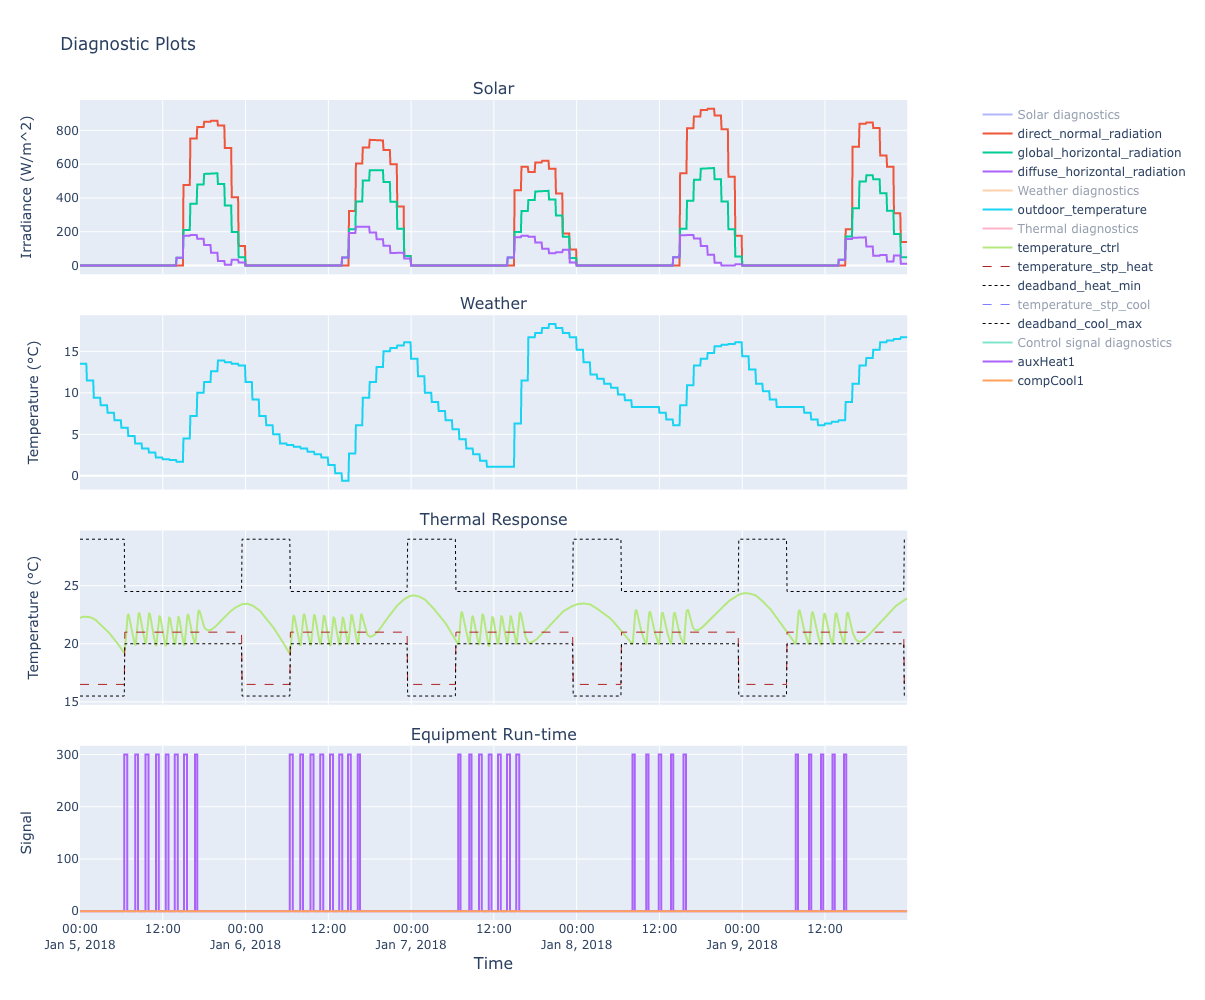

In [12]:
sim_analysis = OutputAnalysis(simulations=simulator.simulations, data_spec=dummy_data_client.internal_spec)
sim_analysis.diagnostic_plot(show=True, actuals=False)